## Image Localization

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

import os
import re
import shutil
import xml.etree.ElementTree as et
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'annotations',
 'annotations.tar.gz',
 'DL_Image_Classification.ipynb',
 'DL_Image_Localization.ipynb',
 'images',
 'images.tar.gz',
 'Intro.ipynb',
 'tfrecord',
 'train',
 'validation']

In [3]:
image_dir = os.path.join(os.getcwd(), 'images') 
bbox_dir = os.path.join(os.getcwd(), 'annotations', 'xmls')
seg_dir = os.path.join(os.getcwd(), 'annotations', 'trimaps')

In [8]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
len(image_files)

7390

In [9]:
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
len(bbox_files)

3686

In [12]:
## 이 전에 삭제한 channel이 3이 아니었던 image와 연결되는 xml file을 함께 삭제
for file in tqdm(image_files):
    image_path = os.path.join(image_dir, file)
    bbox_file = os.path.splitext(file)[0] + '.xml'
    bbox_path = os.path.join(bbox_dir, bbox_file)
    
    with Image.open(image_path) as im:
        image = im
    
    if image.mode != 'RGB':
        os.remove(image_path)
        try:
            print(bbox_path)
            os.remove(bbox_path)
        except FileNotFoundError:
            pass

  7%|▋         | 529/7390 [00:00<00:02, 2721.90it/s]

C:\Users\user\DeepLearning\Part 6\annotations\xmls\Abyssinian_34.xml
C:\Users\user\DeepLearning\Part 6\annotations\xmls\Abyssinian_5.xml


 33%|███▎      | 2455/7390 [00:01<00:02, 2078.33it/s]

C:\Users\user\DeepLearning\Part 6\annotations\xmls\Egyptian_Mau_129.xml
C:\Users\user\DeepLearning\Part 6\annotations\xmls\Egyptian_Mau_139.xml
C:\Users\user\DeepLearning\Part 6\annotations\xmls\Egyptian_Mau_14.xml
C:\Users\user\DeepLearning\Part 6\annotations\xmls\Egyptian_Mau_145.xml
C:\Users\user\DeepLearning\Part 6\annotations\xmls\Egyptian_Mau_167.xml
C:\Users\user\DeepLearning\Part 6\annotations\xmls\Egyptian_Mau_177.xml
C:\Users\user\DeepLearning\Part 6\annotations\xmls\Egyptian_Mau_186.xml
C:\Users\user\DeepLearning\Part 6\annotations\xmls\Egyptian_Mau_191.xml


 97%|█████████▋| 7156/7390 [00:03<00:00, 2058.82it/s]

C:\Users\user\DeepLearning\Part 6\annotations\xmls\staffordshire_bull_terrier_2.xml
C:\Users\user\DeepLearning\Part 6\annotations\xmls\staffordshire_bull_terrier_22.xml


100%|██████████| 7390/7390 [00:03<00:00, 2134.18it/s]


In [13]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']

len(image_files), len(bbox_files)

(7378, 3685)

In [14]:
# class list 만들기
class_list = set()

for file in image_files:
    file_name = os.path.splitext(file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
    
class_list = list(class_list)
class_list.sort()
print(len(class_list))
class_list

37


['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [15]:
# class labeling
class_idx = {cls:idx for idx, cls in enumerate(class_list)}
class_idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [16]:
img_size = 224

num_bbox = len(bbox_files)
num_train = 3000
num_val = num_bbox - num_train

In [17]:
# TFRecord 저장할 directory와 file 경로
tfr_dir = os.path.join(os.getcwd(), 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

# TFRecord writer
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [18]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [19]:
shuffle_list = list(range(num_bbox))
np.random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:num_train]
val_idx_list = shuffle_list[num_train:]

len(train_idx_list), len(val_idx_list)

(3000, 685)

In [20]:
## Train Data
for idx in tqdm(train_idx_list):
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)
    
    # bbox의 좌표 가져오기
    tree = et.parse(bbox_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)
    x_min = float(tree.find('./object/bndbox/xmin').text)
    x_max = float(tree.find('./object/bndbox/xmax').text)
    y_min = float(tree.find('./object/bndbox/ymin').text)
    y_max = float(tree.find('./object/bndbox/ymax').text)
    
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    
    ## 중심점의 좌표를 정규화 (0-1)
    x = x_center / width
    y = y_center / height
    
    w = (x_max - x_min) / width
    h = (y_max - y_min) / height
    
    # 출력을 위한 이미지
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((img_size, img_size))
    b_image = image.tobytes()
    
    class_name = re.sub('_\d+', '', file_name)
    class_num = class_idx[class_name]
    
    if file_name[0].islower():   # 강아지
        bi_cls_num = 0
    else:
        bi_cls_num = 1   # 고양이
        
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(b_image), 
        'cls_num': _int64_feature(class_num), 
        'bi_cls_num': _int64_feature(bi_cls_num), 
        'x': _float_feature(x),
        'y': _float_feature(y), 
        'w': _float_feature(w), 
        'h': _float_feature(h)
    }))
    
    # TFRecord 에 기록
    writer_train.write(example.SerializeToString())
    
writer_train.close()

100%|██████████| 3000/3000 [00:26<00:00, 111.45it/s]


In [21]:
## Validation Data
for idx in tqdm(val_idx_list):
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)
    
    # bbox의 좌표 가져오기
    tree = et.parse(bbox_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)
    x_min = float(tree.find('./object/bndbox/xmin').text)
    x_max = float(tree.find('./object/bndbox/xmax').text)
    y_min = float(tree.find('./object/bndbox/ymin').text)
    y_max = float(tree.find('./object/bndbox/ymax').text)
    
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    
    ## 중심점의 좌표를 정규화 (0-1)
    x = x_center / width
    y = y_center / height
    
    w = (x_max - x_min) / width
    h = (y_max - y_min) / height
    
    # 출력을 위한 이미지
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((img_size, img_size))
    b_image = image.tobytes()
    
    class_name = re.sub('_\d+', '', file_name)
    class_num = class_idx[class_name]
    
    if file_name[0].islower():   # 강아지
        bi_cls_num = 0
    else:
        bi_cls_num = 1   # 고양이
        
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(b_image), 
        'cls_num': _int64_feature(class_num), 
        'bi_cls_num': _int64_feature(bi_cls_num), 
        'x': _float_feature(x),
        'y': _float_feature(y), 
        'w': _float_feature(w), 
        'h': _float_feature(h)
    }))
    
    # TFRecord 에 기록
    writer_val.write(example.SerializeToString())
    
writer_val.close()

100%|██████████| 685/685 [00:05<00:00, 123.57it/s]


In [22]:
# Hyperparameters
num_class = len(class_list)
num_epochs = 40
batch_size = 40
learning_rate = 0.001
dropout_rate = 0.4
steps_per_epoch = num_train // batch_size
validation_steps = num_val // batch_size + 1

In [23]:
## TFRecord file을 data로 parsing해주는 함수
def parsing_function(tfrecord_serialized):
    # Parsing features
    features = {'image': tf.io.FixedLenFeature([], tf.string), 
               'cls_num': tf.io.FixedLenFeature([], tf.int64), 
               'bi_cls_num': tf.io.FixedLenFeature([], tf.int64), 
               'x': tf.io.FixedLenFeature([], tf.float32), 
               'y': tf.io.FixedLenFeature([], tf.float32), 
               'w': tf.io.FixedLenFeature([], tf.float32), 
               'h': tf.io.FixedLenFeature([], tf.float32)}
    
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    # load image
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [img_size, img_size, 3])
    image = tf.cast(image, tf.float32) / 255.
    
    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    ## 통합해서 return
    gt = tf.stack([x, y, w, h], -1)
    
    return image, gt

In [24]:
# Train Dataset
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(parsing_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(num_train).prefetch(tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).repeat()

In [25]:
# Validation Dataset
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(parsing_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).repeat()

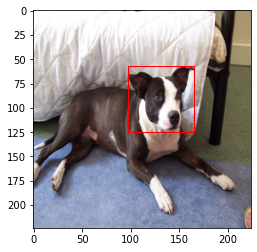

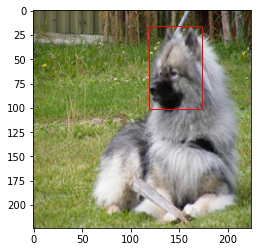

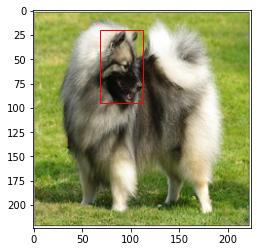

In [26]:
## 출력 test
for image, gt in val_dataset.take(3):
    x = gt[:, 0]   # gt : (40, 4)
    y = gt[:, 1]
    w = gt[:, 2]
    h = gt[:, 3]
    
    x_min = x[0].numpy() - w[0].numpy() / 2.  # center_x - w/2 = min point
    y_min = y[0].numpy() - h[0].numpy() / 2.
    
    rect_x = int(x_min * img_size)
    rect_y = int(y_min * img_size)
    rect_w = int(w[0].numpy() * img_size)
    rect_h = int(h[0].numpy() * img_size)
    
    ## Draw Rectangle
#     (xy)---- width -----+
#      |                  |
#    height               |
#      |                  |
#      +------------------+
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='r')
    
    plt.figure(facecolor='w')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()

### Model

In [27]:
def MyModel():
    ## Vanilla CNN
    model = tf.keras.Sequential()
    
    # Feature Extraction
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(layers.MaxPool2D((2, 2), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPool2D((2, 2), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPool2D((2, 2), padding='same'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPool2D((2, 2), padding='same'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPool2D((2, 2), padding='same'))
    
    # Fully Connected
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(4, activation='sigmoid'))  # x, y, w, h = [0, 1]
    
    return model

In [28]:
def loss_func(target, prediction):
    return tf.keras.losses.MeanSquaredError()(target, prediction)

In [29]:
model = MyModel()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

In [30]:
## lr scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                           decay_steps=steps_per_epoch * 10, 
                                                           decay_rate=0.5,
                                                           staircase=True)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr_schedule), 
              loss=loss_func)

In [31]:
model.fit(train_dataset, 
         steps_per_epoch=steps_per_epoch, 
         epochs=num_epochs, 
         validation_data=val_dataset, 
         validation_steps=validation_steps)

Epoch 1/40
75/75 [==============================] - 13s 69ms/step - loss: 0.0292 - val_loss: 0.0258
Epoch 2/40
75/75 [==============================] - 5s 65ms/step - loss: 0.0242 - val_loss: 0.0230
Epoch 3/40
75/75 [==============================] - 5s 64ms/step - loss: 0.0244 - val_loss: 0.0223
Epoch 4/40
75/75 [==============================] - 5s 64ms/step - loss: 0.0228 - val_loss: 0.0210
Epoch 5/40
75/75 [==============================] - 5s 64ms/step - loss: 0.0207 - val_loss: 0.0189
Epoch 6/40
75/75 [==============================] - 5s 64ms/step - loss: 0.0184 - val_loss: 0.0170
Epoch 7/40
75/75 [==============================] - 5s 64ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 8/40
75/75 [==============================] - 5s 65ms/step - loss: 0.0137 - val_loss: 0.0122
Epoch 9/40
75/75 [==============================] - 5s 64ms/step - loss: 0.0114 - val_loss: 0.0127
Epoch 10/40
75/75 [==============================] - 5s 65ms/step - loss: 0.0094 - val_loss: 0.0129
Epoch 11

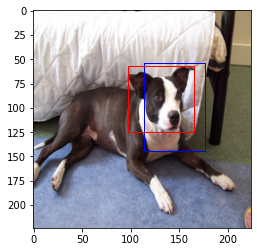

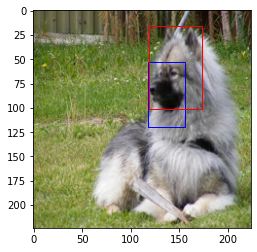

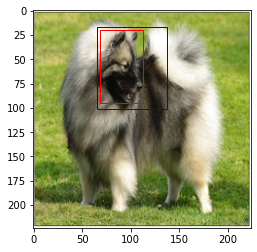

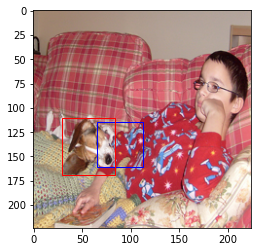

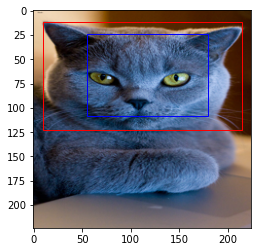

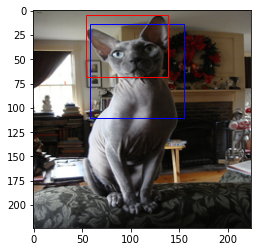

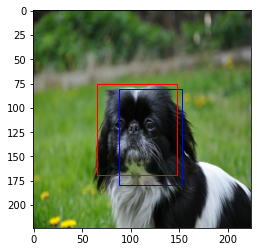

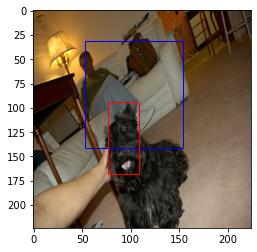

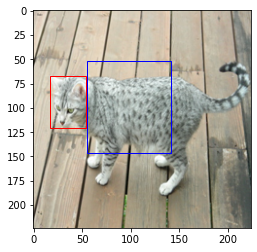

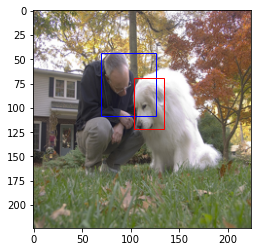

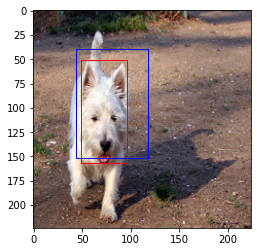

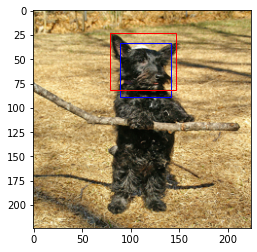

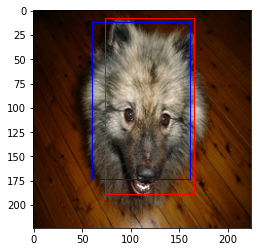

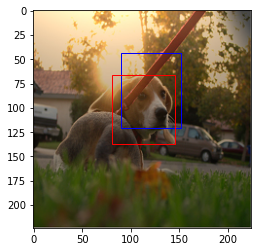

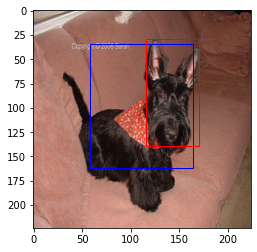

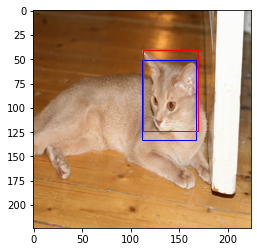

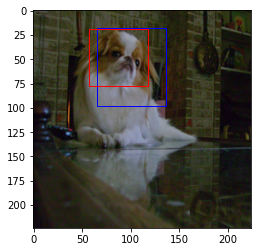

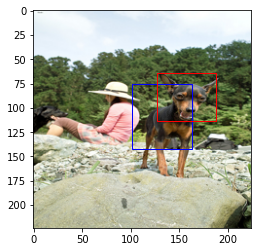

In [53]:
## 정답은 빨간색 box, 예측은 파란색 box
idx = 0
num_imgs = validation_steps

for val_data, val_gt in val_dataset.take(num_imgs):
    ## 정답 box
    x = val_gt[:, 0]
    y = val_gt[:, 1]
    w = val_gt[:, 2]
    h = val_gt[:, 3]
    
    x_min = x[idx].numpy() - w[idx].numpy() / 2.
    y_min = y[idx].numpy() - h[idx].numpy() / 2.
    
    rect_x = int(x_min * img_size)
    rect_y = int(y_min * img_size)
    rect_w = int(w[idx].numpy() * img_size)
    rect_h = int(h[idx].numpy() * img_size)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    
    ## 예측 box
    prediction = model.predict(val_data)
    
    pred_x = prediction[:, 0]
    pred_y = prediction[:, 1]
    pred_w = prediction[:, 2]
    pred_h = prediction[:, 3]
    
    pred_x_min = pred_x[idx] - pred_w[idx] / 2.
    pred_y_min = pred_y[idx] - pred_h[idx] / 2.
    
    pred_rect_x = int(pred_x_min * img_size)
    pred_rect_y = int(pred_y_min * img_size)
    pred_rect_w = int(pred_w[idx] * img_size)
    pred_rect_h = int(pred_h[idx] * img_size)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h, fill=False, color='blue')
    
    ## image
    fig, ax = plt.subplots(facecolor='w')
    ax.add_patch(pred_rect)
    ax.add_patch(rect)
    plt.imshow(val_data[idx])
    plt.show()

Vanilla CNN의 성능으로는 전체적으로 정확도가 좋은 편이 아니다.

-> 다른 고성능의 모델을 사용하면 어느정도 개선될 것이다.